# Q-Learning (Off-Policy Temporal-Difference Method)
This notebook demonstrates Q-learning method with the help of Cart Pole example. For conceptual understanding of this method, refer to [book by Sutton & Barto](https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf) chapter 6. Cart Pole environment is simulated using [OpenAI Gym](https://gym.openai.com/). 

__Acknowledgement__: Code snippets are taken from this [repo](https://github.com/manngithub/machine_learning_examples). Author of this repo has good Udemy courses on Reinforcement Learning. 

## Reinforcement Learning Components
  * [Environment](#Environment)
    * Create/Import Environment
    * Analyze State Variables
  * [Observer](#Observer)
    * State Observer (Feature Generator)
    * Example
  * [Model](#Model)
    * Define Learning Model for Agent 
    * Define Learning Procedure (Q-Learning)
  * [Play the Game](#Play-the-Game)
    * Start an Epoch
    * Use termination criteria
  * [Model Training](#Model-Training)
    * Initialize Parameters
    * Analyze 
  * [Parameters Tuning](#Parameters-Tuning)

In [1]:
# Import Necessary Packages
import gym
import numpy as np

import tqdm
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

## Environment

In [2]:
class Environment:
    # Create or Import your environment here
    def __init__(self):
        self.environment = gym.make('CartPole-v0') # Cart Pole environment
        

In [3]:
# Analyze State Variables
env = Environment().environment
print('State Vector Shape:', env.observation_space.shape)
print('Low Limits:', env.observation_space.low)
print('High Limits:', env.observation_space.high)
print('Draw a Sample:', env.observation_space.sample())

State Vector Shape: (4,)
Low Limits: [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
High Limits: [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
Draw a Sample: [-7.3944169e-01  8.1291284e+37 -1.4755343e-01  2.4536892e+38]


## Observer
Generally, all state variables are not observed in practical problems. In our situation, Cart's and Pole's position and velocity can be measured and available as observation. Also for simplicity, we will transform CartPole's continuous state space to discrete state space.

In [4]:
class Observer:
    def __init__(self, low, high):
        # State Space mapping from Continuous to Discrete 
        # Define discretization
        self.cart_position_bins = np.linspace(low[0], high[0], 9)
        self.cart_velocity_bins = np.linspace(-5, 5, 9)
        self.pole_angle_bins = np.linspace(low[2], high[2], 9)
        self.pole_velocity_bins = np.linspace(-5, 5, 9)
        
    def state_transformer(self, observation):
        # Collect observation variables
        cart_position, cart_velocity, pole_angle, pole_velocity = observation
        #print(cart_position, cart_velocity, pole_angle, pole_velocity)
        
        # State Discretization
        cart_position = self.to_bin(cart_position, self.cart_position_bins)
        cart_velocity = self.to_bin(cart_velocity, self.cart_velocity_bins)
        pole_angle = self.to_bin(pole_angle, self.pole_angle_bins)
        pole_velocity = self.to_bin(pole_velocity, self.pole_velocity_bins)
        return self.feature([cart_position, cart_velocity, pole_angle, pole_velocity])
    
    @staticmethod
    def to_bin(value, bins):
        return np.digitize(x = [value], bins = bins)[0]
    
    @staticmethod
    def feature(state):
        # Combine bin values to integer: [0,1,2,5] => 0125 
        return int("".join(map(lambda feature: str(int(feature)), state)))
    

In [5]:
# Example
obs = Observer(env.observation_space.low,env.observation_space.high)
state = obs.state_transformer(env.observation_space.sample())
print(state)

4919


## Model
Define your Agent Model and Training Procedures
* Linear Model is defined for (state, action) pairs
* Q-learning procedure is defined

In [6]:
class Model:
    def __init__(self, env, obs):
        self.env = env
        self.obs = obs
        num_states = 10**env.observation_space.shape[0]
        num_actions = env.action_space.n
        # Initialize Q for every state
        self.Q = np.random.uniform(low=-1, high=1, size=(num_states, num_actions)) 
    
    def sample_action(self, s, eps):
        # Take a sample action at state s
        
        # Epsilon greedy policy
        if np.random.random() < eps:
            return self.env.action_space.sample() # take a random action
        else:
            return np.argmax(self.predict(s)) # take a greedy action
    
    def predict(self, s):
        # Q-value prediction for state s
        
        # use state transformation
        s = self.obs.state_transformer(s)
        return self.Q[s] # predict for all action levels
    
    def update(self, s, a, G, alpha):
        # Update Q-value for (state, action) pair
        
        # use state transformation
        s = self.obs.state_transformer(s)
        # update Q values
        self.Q[s,a] = self.Q[s,a] + alpha*(G - self.Q[s,a])

## Play the Game

In [7]:
def play_one(model, eps, gamma, alpha):
    # reset the environment
    observation = env.reset()
    # done = True means game is complete
    is_done = False
    # total reward earned in the game
    totalreward = 0
    
    iteration = 0
    # play till game terminates
    # gym terminates the game by default at max_episode_steps; iteration variable is only for safety
    while not is_done and iteration <= model.env.spec.max_episode_steps: 
        action = model.sample_action(observation, eps)
        prev_observation = observation
        observation, reward, is_done, info = env.step(action)

        totalreward = totalreward + reward

        if is_done and iteration < model.env.spec.max_episode_steps:
            reward = -100 # Huge penalty if pole drops below limits within max_episode_steps

        # update the model
        G = reward + gamma*np.max(model.predict(observation))
        model.update(prev_observation, action, G, alpha)
        
        iteration = iteration + 1

    return totalreward, iteration

## Model Training

In [8]:
# Create a Model Object
model = Model(env, obs)

# Tuning Parameters
gamma, alpha = 0.9, 0.01

# Training Epochs
N = 100000
totalrewards, iterations, epsilons = np.empty(N), np.empty(N), np.empty(N)

for n in tqdm.tqdm(range(N)):
    eps = 1.0/np.sqrt(n+1) # Tuning Parameter
    totalreward, iteration = play_one(model, eps, gamma, alpha)
    totalrewards[n] = totalreward
    iterations[n] = iteration
    epsilons[n] = eps

100%|██████████| 100000/100000 [38:09<00:00, 43.69it/s]


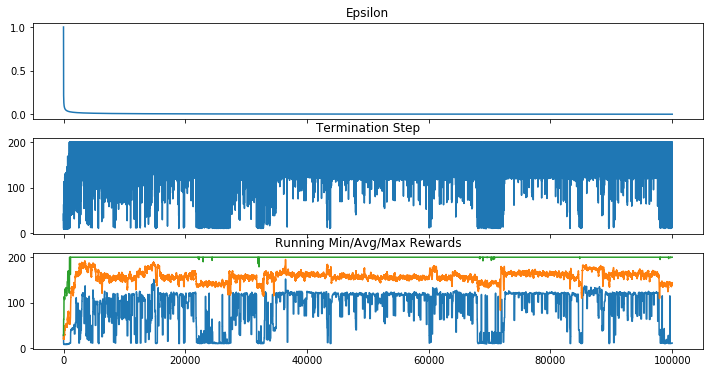

In [9]:
# Analyze Model Training
def plots_running_avg(totalrewards, iterations, epsilons):
    N = len(totalrewards)
    running_min_rewards = np.empty(N)
    running_avg_rewards = np.empty(N)
    running_max_rewards = np.empty(N)
    for t in range(N):
        running_min_rewards[t] = totalrewards[max(0, t-100):(t+1)].min()
        running_avg_rewards[t] = totalrewards[max(0, t-100):(t+1)].mean()
        running_max_rewards[t] = totalrewards[max(0, t-100):(t+1)].max()
    
    fig, ax = plt.subplots(3,1,figsize=(12,6),sharex=True)
    
    ax[0].plot(epsilons)
    ax[0].set_title("Epsilon")
    
    ax[1].plot(iterations)
    ax[1].set_title("Termination Step")
    
    ax[2].plot(running_min_rewards)
    ax[2].plot(running_avg_rewards)
    ax[2].plot(running_max_rewards)
    ax[2].set_title("Running Min/Avg/Max Rewards")
    
    plt.show()
    
plots_running_avg(totalrewards, iterations, epsilons)

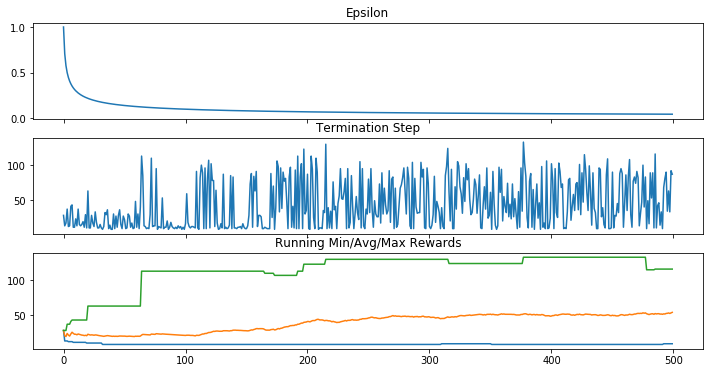

In [10]:
epoch = 500
plots_running_avg(totalrewards[:epoch], iterations[:epoch], epsilons[:epoch])

- In the beginning, epoch terminated mostly in early stages (before 200 steps)
- As Model started learning, Agent also started reaching max 200 steps

## Parameters Tuning
 - Discretization Steps
 - Exploration vs Exploitation
 - Reward Structure
 - Decay Rate (generally fixed), Learning Rate
 